# **DATA VISUALIZATION AND TEXT MINING PROJECT**

> *This project was carried out by: Lorenzo Conte, Martina Dotti, Filippo Elmino and Alessia Guarneri*



## Dependencies import

In [ ]:
import pandas as pd
import csv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Bidirectional, LSTM, Flatten, GlobalMaxPool1D, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
! pip install seqeval
from seqeval.metrics import classification_report
from keras.models import Sequential
from keras.layers import Embedding, Dropout, Flatten, Dense
from wordcloud import WordCloud, STOPWORDS
import urllib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 468.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=c844926ab34030cbf22dc30b9de906e2f57b37a1c20584ef774c9f725e39aefe
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
!pip install dash
!pip install dash-core-components dash-html-components

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 5.8 MB/s eta 0:00:00


In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px
from dash.dependencies import Input, Output

<ipython-input-3-ed9529665e73>:2: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-3-ed9529665e73>:3: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


## Data Loading and preprocessing


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Text mining')
from utils import kerasutils, modelutils

The previous packages are imported from the Utils folder created by the Professor Andrea Belli and stored in the directory mentioned above. The packages contain functions that are going to be useful when dealing with the evaluation of the models performance on the test set.

 The dataset that we have used in our project is **wikigold.conll.txt**, a manually annotated collection of Wikipedia text. The format of the dataset is the Conll-03 format, the reference for named entity recognition.

In [ ]:
file_path = 'https://media.githubusercontent.com/media/nluninja/nlp_datasets/main/wikigold/data/wikigold.conll.txt'

In [ ]:
data = pd.read_csv(file_path, sep=' ', header=None, names=['Token', 'Tag'], quoting=csv.QUOTE_NONE)
data

,Token,Tag
0,010,I-MISC
1,is,O
2,the,O
3,tenth,O
4,album,O
...,...,...
39147,a,O
39148,Russian,I-MISC
39149,singer,O
39150,.,O


As it is possible to see our dataset uses the IOB-tagging annotation scheme. IOB stands for Inside-Outside-Beginning, meaning each tag indicates whether the corresponding word is inside, outside, or at the beginning of a specific named entity.

In [ ]:
# number of rows
len(data)

39152

In [ ]:
# check NaN
data.isnull().sum()

Token    0
Tag      0
dtype: int64

In [ ]:
# Detect empty string

blanks = []
for index,label,review in data.itertuples():
    if type(review)==str:
        if review.isspace():
            blanks.append(index)

blanks

[]

First of all, we verified the possible presence of missing values and empty strings, and as you can see from the codes above, such searches yielded negative results.

We have created two dictionaries: one that associates individual tags with indices and another that links indices to their respective tags.

In [ ]:
labels_to_ids = {k: v for v, k in enumerate(data.Tag.unique())}
ids_to_labels = {v: k for v, k in enumerate(data.Tag.unique())}

In [ ]:
# tag
labels_to_ids

{'I-MISC': 0, 'O': 1, 'I-ORG': 2, 'I-PER': 3, 'I-LOC': 4}

Our dataset considers 5 distinct named entities, which are: MISC (it stands for miscellaneous meaning entities that don't belong to the others tags), O (it stands for token outside the entity), ORG (it stands for organization), PER (it stands for person), LOC (it stands for location).



We decided to group the tokens into sentences. We considered the dot, exclamation mark, and question mark as elements indicating the end of a sentence.

In [ ]:
data['Sentence #'] = 0

sentence_count = 1

for i in range(len(data)):
    if data['Token'][i] in ['.', '!', '?']:
        sentence_count += 1
    data.at[i, 'Sentence #'] = f'Sentence: {sentence_count}'

data

,Token,Tag,Sentence #
0,010,I-MISC,Sentence: 1
1,is,O,Sentence: 1
2,the,O,Sentence: 1
3,tenth,O,Sentence: 1
4,album,O,Sentence: 1
...,...,...,...
39147,a,O,Sentence: 1660
39148,Russian,I-MISC,Sentence: 1660
39149,singer,O,Sentence: 1660
39150,.,O,Sentence: 1661


Through the creation of a "Filtered" column (which was later removed), we generated a new dataset named 'wiki' that includes only the rows from the original dataframe where the tokens are neither punctuation symbols nor tokens to be removed.

In [ ]:
punctuation = {'.', ',', ';', ':', '?', '!'}
remove_tokens = ['-DOCSTART-']

data.loc[:, 'Filtered'] = ~((data['Token'].isin(punctuation)) | (data['Token'].isin(remove_tokens)))
wiki = data.loc[data['Filtered']]
wiki = wiki.drop(columns=['Filtered'])

wiki

,Token,Tag,Sentence #
0,010,I-MISC,Sentence: 1
1,is,O,Sentence: 1
2,the,O,Sentence: 1
3,tenth,O,Sentence: 1
4,album,O,Sentence: 1
...,...,...,...
39145,Gazmanov,I-PER,Sentence: 1660
39146,is,O,Sentence: 1660
39147,a,O,Sentence: 1660
39148,Russian,I-MISC,Sentence: 1660


In [ ]:
len(wiki)

35150

# 1. Exploratory analysis


We have created two columns, 'sentence' and 'word_labels', which group the words by sentence and the tags by sentence respectively.

In [ ]:
wiki['sentence'] = wiki[['Sentence #','Token','Tag']].groupby(['Sentence #'])['Token'].transform(lambda x: ' '.join(x))
wiki['word_labels'] = wiki[['Sentence #','Token','Tag']].groupby(['Sentence #'])['Tag'].transform(lambda x: ','.join(x))

wiki.head()

,Token,Tag,Sentence #,sentence,word_labels
0,010,I-MISC,Sentence: 1,010 is the tenth album from Japanese Punk Tech...,"I-MISC,O,O,O,O,O,I-MISC,O,O,O,I-ORG,I-ORG,I-OR..."
1,is,O,Sentence: 1,010 is the tenth album from Japanese Punk Tech...,"I-MISC,O,O,O,O,O,I-MISC,O,O,O,I-ORG,I-ORG,I-OR..."
2,the,O,Sentence: 1,010 is the tenth album from Japanese Punk Tech...,"I-MISC,O,O,O,O,O,I-MISC,O,O,O,I-ORG,I-ORG,I-OR..."
3,tenth,O,Sentence: 1,010 is the tenth album from Japanese Punk Tech...,"I-MISC,O,O,O,O,O,I-MISC,O,O,O,I-ORG,I-ORG,I-OR..."
4,album,O,Sentence: 1,010 is the tenth album from Japanese Punk Tech...,"I-MISC,O,O,O,O,O,I-MISC,O,O,O,I-ORG,I-ORG,I-OR..."


## 1.1 **Bar chart visualization for sentences**

In [ ]:
tag_colors = {
    'O': 'rgb(0, 255, 0)',
    'I-PER': 'rgb(255, 0, 0)',
    'I-MISC': 'rgb(255, 165, 0)',
    'I-LOC': 'rgb(128, 0, 128)',
    'I-ORG': 'rgb(0, 128, 0)'}

Here we are defining the different colors the entities will have when creating the dashboard.

The first dashboard is a simple Bar chart. We decide to create a dashboard that allows to navigate through all the sentences available in the dataset and visualizing the corresponding entities present in them.

In [ ]:
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Token Tag Visualization"),

    dcc.Dropdown(
        id='sentence-dropdown',
        options=[{'label': sentence, 'value': sentence} for sentence in wiki['Sentence #'].unique()],
        value=wiki['Sentence #'].unique()[0],
        multi=False,
    ),

    dcc.Graph(id='token-tag-graph'),
])

@app.callback(
    Output('token-tag-graph', 'figure'),
    [Input('sentence-dropdown', 'value')]
)
def update_graph(selected_sentence):
        filtered_df = wiki[wiki['Sentence #'] == selected_sentence]
        sen_text = wiki[wiki['Sentence #'] == selected_sentence]['sentence'].unique()[0]
        figure = {
            'data': [
                {'x': filtered_df['Tag'], 'y': filtered_df['Token'], 'type': 'bar', 'name': 'Token Tags',
                 'marker': {'color': [tag_colors.get(tag, 'rgb(128, 128, 128)') for tag in filtered_df['Tag']]}},
            ],
            'layout': {
                'title': f'Sentence:  {sen_text}',
                'xaxis': {'title': 'Tag', 'categoryorder': 'category ascending', 'automargin': True},
                'yaxis': {'title': 'Token', 'visible': False},
            }
        }

        return figure

if __name__ == '__main__':
    app.run_server(debug=True, port = 1234)

<IPython.core.display.Javascript object>

In the x-axis we have the different entities of the corresponding sentence, while in the y-axis we have the counts of the entities. The dashboard allows not only to visualize the sentence we are currently selecting but also to see which word correspond to proper entity, by moving the cursor in the image.

## 1.2 **Pie chart visualization for sentences**

The second dashboard is similar to the first one, however here we have a Pie chart instead of a bar chart. Also in this case we have a dropdown dash that allows to navigate trough the different sentences of the dataset, the graph display the corresponding percentages of the entities that are present in the selected sentence.

In [ ]:
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Tag Distribution Visualization"),
    dcc.Dropdown(
         id='sentence-dropdown',
         options=[{'label': sentence, 'value': sentence} for sentence in wiki['Sentence #'].unique()],
         value=wiki['Sentence #'].unique()[0],
         multi=False,
    ),
    dcc.Graph(id='tag-distribution-pie-chart'),
    ])


@app.callback(
    Output('tag-distribution-pie-chart', 'figure'),
    [Input('sentence-dropdown', 'value')]
)

def update_tag_distribution_pie_chart(selected_sentence):

    filtered_df = wiki[wiki['Sentence #'] == selected_sentence]

    tag_counts = filtered_df['Tag'].value_counts()

    figure = px.pie(tag_counts, names=tag_counts.index, values=tag_counts.values,
                    title='Tag Distribution')

    return figure


if __name__ == '__main__':
    app.run_server(debug=True, port = 4567)

<IPython.core.display.Javascript object>

## 1.3 **Wordcloud and LDA**

Here we decide to plot the wordcloud of the entire dataset because we want to find which are the more frequent words. \
The reason is because we have many documents that correspond to different Wikipedia pages and the topics are different. Using the wordcloud we would have a clearer idea about how the documents are connected with each other, by identifying different groups of word.

In [ ]:
punt = {'.', ',', ';',':','?', '!'}
text = ''
for i in data['Token']:
  if i in punt:
    text = text + i
  else:
    text = text + ' ' + i
text

' 010 is the tenth album from Japanese Punk Techno band The Mad Capsule Markets. This album proved to be more commercial and more techno-based than Osc-Dis, with heavily synthesized songs like Introduction 010 and Come. Founding member Kojima Minoru played guitar on Good Day, and Wardanceis cover of a song by UK post punk industrial band Killing Joke. XXX can of This had a different meaning, and most people did n\'t understand what the song was about. it was later explained that the song was about Cannabis ( \' can of this \' sounding like Cannabis when said faster ) it is uncertain if they were told to change the lyric like they did on P.O.P and HUMANITY. UK Edition came with the OSC-DIS video, and most of the tracks were re-engineered. -DOCSTART- The 139th was formed at Camp Howe, near Pittsburgh, on September 1, 1862. Frederick H. Collier was the first colonel. After burying the dead on the field of Second Battle of Bull Run, the regiment was attached to Howe \'s Brigade of Couch \'

In [ ]:
stopwords = set(STOPWORDS)
# we add some stopwords that gives us some problem in the cloud
stopwords.add('DOCSTART')
stopwords.add('S')
wiki_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
wiki_wc.generate(text)

After that we generate the wordcloud in the above cell we plot it using the code define below.  

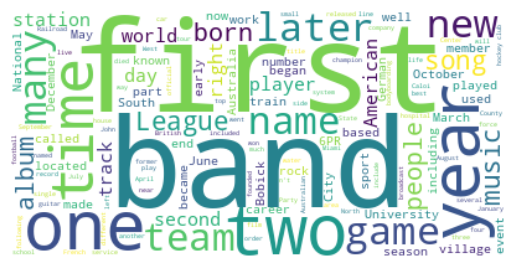

In [ ]:
plt.imshow(wiki_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

As we can see from the plot the most popular words are not very similar, however it can be seen that some of them are in some way related with each other meaning that could exist some topic that are more present in the documents. Words like *band, music, rock, track, album* refers probably to a topic related with **music**; on the other hand words like *game, league, national, player, season, sport* could refer to **sporting events**.

In order to further investigate this, we apply the **Latent Dirichlet Allocation** to find some topics that hopefully summarise the dataset.  

To obtain a cleaner and organized dataset, we modified it by considering only the "sentence" and "word_labels" columns. We removed duplicates based on these columns and then reorganized the indices.

In [ ]:
wiki = wiki[["sentence", "word_labels"]].drop_duplicates().reset_index(drop=True)
wiki.head()

,sentence,word_labels
0,010 is the tenth album from Japanese Punk Tech...,"I-MISC,O,O,O,O,O,I-MISC,O,O,O,I-ORG,I-ORG,I-OR..."
1,This album proved to be more commercial and mo...,"O,O,O,O,O,O,O,O,O,O,O,I-MISC,O,O,O,O,O,I-MISC,..."
2,Founding member Kojima Minoru played guitar on...,"O,O,I-PER,I-PER,O,O,O,I-MISC,I-MISC,O,I-MISC,O..."
3,XXX can of This had a different meaning and mo...,"I-MISC,I-MISC,I-MISC,I-MISC,O,O,O,O,O,O,O,O,O,..."
4,it was later explained that the song was about...,"O,O,O,O,O,O,O,O,O,I-MISC,O,O,O,O,O,O,O,O,I-MIS..."


In [ ]:
wiki['sentence']

0       010 is the tenth album from Japanese Punk Tech...
1       This album proved to be more commercial and mo...
2       Founding member Kojima Minoru played guitar on...
3       XXX can of This had a different meaning and mo...
4       it was later explained that the song was about...
                              ...                        
1650    This major has been gaining recognition for FS...
1651    The Robert C. Byrd National Aerospace Educatio...
1652    Fairmont State 's athletic teams known as the ...
1653                  A list of works by Justin Broadrick
1654       Oleg Mikhaylovich Gazmanov is a Russian singer
Name: sentence, Length: 1655, dtype: object

In [ ]:
#convert a collection of text documents to a matrix of token counts.
cv = CountVectorizer(max_df=0.99, min_df=0.01, stop_words='english')

dtm = cv.fit_transform(wiki['sentence'])

#dtm represents the frequency of words in the sentences.
dtm

<1655x103 sparse matrix of type '<class 'numpy.int64'>'
	with 2577 stored elements in Compressed Sparse Row format>

In [ ]:
LDA = LatentDirichletAllocation(n_components=4, random_state=42)
LDA.fit(dtm)

LatentDirichletAllocation(n_components=4, random_state=42)

Once we define the algorithm we decide to show the top 20 words per topic in order to identify better what the topic refer to.

In [ ]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 20 WORDS FOR TOPIC #{index+1}')
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[-20:]])
    print('\n')

THE TOP 20 WORDS FOR TOPIC #1
['did', 'tour', 'died', 'house', 'won', 'released', 'august', '2007', 'rock', 'career', 'october', '30', 'song', '000', 'known', 'album', 'born', 'music', 'world', 'band']


THE TOP 20 WORDS FOR TOPIC #2
['track', 'budjana', 'area', 'near', 'season', 'used', '10', 'september', 'early', 'north', 'just', 'bobick', 'people', 'march', 'located', 'day', 'university', 'train', 'city', 'time']


THE TOP 20 WORDS FOR TOPIC #3
['right', 'like', 'high', 'center', 'french', 'british', 'county', 'left', 'australian', 'german', 'including', 'australia', 'events', 'based', 'school', 'called', 'year', 'national', 'league', 'new']


THE TOP 20 WORDS FOR TOPIC #4
['major', 'current', 'june', 'bodyboarding', 'american', 'village', 'milepost', 'club', 'state', 'small', 'air', 'played', '2006', 'hockey', 'game', 'team', 'station', 'player', 'years', 'later']




After some try the we obtain the best result defining the algorithm with **4 topics**, that we can explain as follow:


1.   The first one seem to refer to a **musical** topic.
2.   The second one is the most difficult to explain, it seems to refer to the **unversity** area.
3. The third one refers to **national events**.
4. The last one is the topic **sport** related.




Despite the division into topics, we are aware that it is not so effective. In fact, it is not immediately clear what the individual topic refers to, and, in particular, the second one is almost impossible. In our opinion, the reason is to be attributed to the fact that the documents are practically independent in terms of the topics they cover.

# 2. Neural Network approach for NER

Let's start by implementing neural network approaches for named entity recognition.

To obtain a cleaner and organized dataset, we modified it by considering only the "sentence" and "word_labels" columns. We removed duplicates based on these columns and then reorganized the indices.

In [ ]:
wiki = wiki[["sentence", "word_labels"]].drop_duplicates().reset_index(drop=True)
wiki.head()

,sentence,word_labels
0,010 is the tenth album from Japanese Punk Tech...,"I-MISC,O,O,O,O,O,I-MISC,O,O,O,I-ORG,I-ORG,I-OR..."
1,This album proved to be more commercial and mo...,"O,O,O,O,O,O,O,O,O,O,O,I-MISC,O,O,O,O,O,I-MISC,..."
2,Founding member Kojima Minoru played guitar on...,"O,O,I-PER,I-PER,O,O,O,I-MISC,I-MISC,O,I-MISC,O..."
3,XXX can of This had a different meaning and mo...,"I-MISC,I-MISC,I-MISC,I-MISC,O,O,O,O,O,O,O,O,O,..."
4,it was later explained that the song was about...,"O,O,O,O,O,O,O,O,O,I-MISC,O,O,O,O,O,O,O,O,I-MIS..."


## 2.1. Training - Validation - Test set

We divided our dataset initially into a training set and a test set (20% test set and 80% training set).\
Subsequently, we further divided the training set to obtain a validation set (20%) and a refined training set (80%). Validation set is useful to improve generalization capabilities of the model.

In [ ]:
# Training and Test set
X_train_val, X_test, y_train_val, y_test = train_test_split(wiki.sentence, wiki.word_labels, test_size=0.20, random_state=200)

# Training and Validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val, test_size=0.2, random_state=200)

In [ ]:
print("Train:", len(X_train))
print("Validation:", len(X_val))
print("Test:", len(X_test))


Train: 1059
Validation: 265
Test: 331


In [ ]:
print(X_train[0])
print(y_train[0])

010 is the tenth album from Japanese Punk Techno band The Mad Capsule Markets
I-MISC,O,O,O,O,O,I-MISC,O,O,O,I-ORG,I-ORG,I-ORG,I-ORG


In [ ]:
# resetting the index

x_train=X_train.reset_index(drop=True)
x_test=X_test.reset_index(drop=True)
x_val=X_val.reset_index(drop=True)

y_train=y_train.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)
y_val=y_val.reset_index(drop=True)

In [ ]:
x_train

0                       She was forced to retreat to Abra
1       Confete is composed by Ruby Tuesday ( < - Carl...
2       none none Per bend azure and gules issuant fro...
3       He was born in Satu Mare and debuted in Divizi...
4       Passengers between these two stations must tra...
                              ...                        
1054    There were 2 storage sidings and 4 spurs servi...
1055    The present temple in Narve Bicholim was rebui...
1056    Radio in Australia was just twelve years old w...
1057    Claire Keim ( born July 8 1975 ) is a French a...
1058    " Snoke was elected a Fellow of the American S...
Name: sentence, Length: 1059, dtype: object

In [ ]:
def splitting_sentence(x,y):
  x_list=[]
  y_list=[]

  for i in range(len(x)):
    sentence=x[i]
    # Splits the sentence into words using space as a delimiter
    splitted_sentence=sentence.split(" ")
    x_list.append(splitted_sentence)

  for j in range(len(y)):
    tags=y[j]
    # Splits word_labels using a comma as a delimiter
    splitted_tags=tags.split(",")
    y_list.append(splitted_tags)

  return x_list, y_list

This function will help us to have the sentences in the correct format to apply the tokenizer.

In [ ]:
# train
x_train_l,y_train_l=splitting_sentence(x_train,y_train)

# test
x_test_l,y_test_l=splitting_sentence(x_test,y_test)

# validation
x_val_l,y_val_l=splitting_sentence(x_val,y_val)

We instantiated a tokenizer to train a model on the words present in x_train_l, x_val_l, and x_test_l. \
Training the tokenizer involves building a vocabulary of the words present and assigning a unique index to each word.\
The previously trained tokenizer is used to convert the lists of texts, x_train_l, x_test_l, and x_val_l, into sequences of numerical indices.\
Finally, we created lists of sequences of numerical indices, where each sequence represents the labels converted into numerical indices using the mapping defined by labels_to_ids.


In [ ]:
# tokenizer
tokenizer=Tokenizer()
tokenizer.fit_on_texts(x_train_l+x_val_l+x_test_l)

# sequences
train_sequences=tokenizer.texts_to_sequences(x_train_l)
test_sequences=tokenizer.texts_to_sequences(x_test_l)
val_sequences=tokenizer.texts_to_sequences(x_val_l)

ner_train_sequences=[[labels_to_ids[tag] for tag in sentence] for sentence in y_train_l]
ner_test_sequences=[[labels_to_ids[tag] for tag in sentence] for sentence in y_test_l]
ner_val_sequences=[[labels_to_ids[tag] for tag in sentence] for sentence in y_val_l]


In [ ]:
print(x_test_l[120])

['883JIA', 'FM', 'is', 'a', 'Chinese', 'radio', 'station', 'of', 'SAFRA', 'Radio', 'in', 'Singapore']


In [ ]:
print(test_sequences[120])

[2480, 2481, 9, 5, 1279, 336, 81, 2, 7107, 336, 3, 2836]


In [ ]:
for i in test_sequences[120]:
  print(f' {i}: {tokenizer.index_word[i]}')

 2480: 883jia
 2481: fm
 9: is
 5: a
 1279: chinese
 336: radio
 81: station
 2: of
 7107: safra
 336: radio
 3: in
 2836: singapore


In [ ]:
# dimension of the vocabulary
vocabulary_size=len(tokenizer.word_counts)
print(vocabulary_size)

7719


In [ ]:
print(x_train[1])

Confete is composed by Ruby Tuesday ( < - Carlos Carlos is singer )


In [ ]:
print(ner_train_sequences[1])

[0, 1, 1, 1, 2, 2, 1, 1, 1, 3, 3, 1, 1, 1]


In [ ]:
for i in ner_train_sequences[1]:
  print(f'{i}: {ids_to_labels[i]}')

0: I-MISC
1: O
1: O
1: O
2: I-ORG
2: I-ORG
1: O
1: O
1: O
3: I-PER
3: I-PER
1: O
1: O
1: O


*sequence_len* is an array that contains the lengths of each sequence in the list *train_sequences*. Then, we identified the longest sequence.

In [ ]:
sequence_len = np.array([len(s) for s in train_sequences])
longest_sequence = sequence_len.max()
print(f'Longest sequence: {longest_sequence}')


Longest sequence: 99


In [ ]:
print([(str(p) + '%', np.percentile(sequence_len, p)) for p in range(75,101, 5)])


[('75%', 26.0), ('80%', 28.0), ('85%', 33.0), ('90%', 37.0), ('95%', 45.0), ('100%', 99.0)]


In order to visualize the distribution of the lenght of the sequences we provided a boxplot.

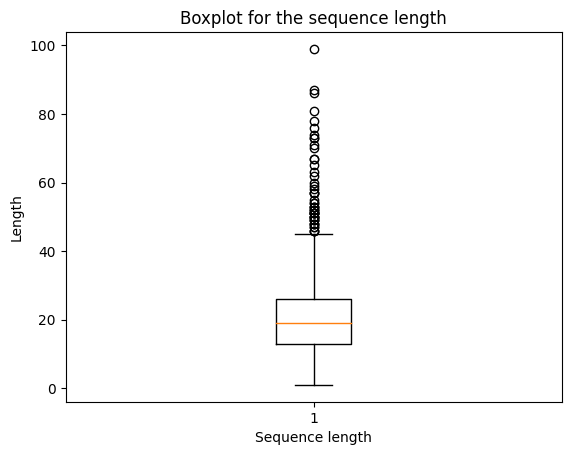

In [ ]:
# Boxplot

plt.boxplot(sequence_len)
plt.xlabel('Sequence length')
plt.ylabel('Length')
plt.title('Boxplot for the sequence length')

plt.show()

We decided to apply the **padding** technique to our sequences with the goal of achieving sequences of equal length. If a sequence is shorter than the designated length, we add as many zeros as needed to reach the target length. If the starting length is greater, the sequence is truncated at the end (truncating=post).\
 Since we set *max_sequence_len* to be equal to 100, and 100% of the sentences contain 99 tokens in our case, it means that only the appropriate number of zeros will be added.

In [ ]:
max_sequence_len = 100

x_train = pad_sequences(train_sequences, maxlen=max_sequence_len, padding='post', truncating='post')
x_test = pad_sequences(test_sequences, maxlen=max_sequence_len, padding='post', truncating='post')
x_val = pad_sequences(val_sequences, maxlen=max_sequence_len, padding='post', truncating='post')

y_train = pad_sequences(ner_train_sequences, maxlen=max_sequence_len, value=labels_to_ids['O'], padding='post', truncating='post')
y_test = pad_sequences(ner_test_sequences, maxlen=max_sequence_len, value=labels_to_ids['O'], padding='post', truncating='post')
y_val = pad_sequences(ner_val_sequences, maxlen=max_sequence_len, value=labels_to_ids['O'], padding='post', truncating='post')


In [ ]:
print(x_train[0])

[  55    7  537    6 3294    6 2038    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [ ]:
# one hot encoding
y_train = to_categorical(y_train, num_classes=len(labels_to_ids), dtype='int32')
y_test = to_categorical(y_test, num_classes=len(labels_to_ids), dtype='int32')
y_val = to_categorical(y_val, num_classes=len(labels_to_ids), dtype='int32')

In [ ]:
print(y_train[0])

[[0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]

In [ ]:
# We transformed 0 into 'PAD'
tokenizer.index_word[0] = '_PAD_'

In [ ]:
# conversion to arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)

x_val = np.array(x_val)
y_val = np.array(y_val)

In [ ]:
tokenizer.word_index

{'the': 1,
 'of': 2,
 'in': 3,
 'and': 4,
 'a': 5,
 'to': 6,
 'was': 7,
 '"': 8,
 'is': 9,
 'on': 10,
 'with': 11,
 '(': 12,
 ')': 13,
 'for': 14,
 'as': 15,
 'he': 16,
 'by': 17,
 "'s": 18,
 'his': 19,
 'at': 20,
 'from': 21,
 'it': 22,
 'that': 23,
 'were': 24,
 'an': 25,
 'which': 26,
 'also': 27,
 'has': 28,
 'they': 29,
 'their': 30,
 'its': 31,
 'who': 32,
 'this': 33,
 'after': 34,
 'one': 35,
 'first': 36,
 'but': 37,
 'are': 38,
 'two': 39,
 '-': 40,
 'had': 41,
 'band': 42,
 "'": 43,
 'be': 44,
 'or': 45,
 '&': 46,
 'later': 47,
 'not': 48,
 'all': 49,
 'other': 50,
 'league': 51,
 'have': 52,
 'new': 53,
 'many': 54,
 'she': 55,
 'when': 56,
 'would': 57,
 'during': 58,
 'her': 59,
 '--': 60,
 'world': 61,
 'over': 62,
 'been': 63,
 'music': 64,
 'out': 65,
 'there': 66,
 'more': 67,
 'name': 68,
 'years': 69,
 '2007': 70,
 '#': 71,
 'player': 72,
 'born': 73,
 'city': 74,
 'album': 75,
 'people': 76,
 'into': 77,
 'him': 78,
 'train': 79,
 'where': 80,
 'station': 81,
 'som

## 2.2. Glove vectorization

**Word embedding** is a technique for the numerical representation of words in a way that preserves the semantic relationships between them. A word embedding associates each word with a numerical vector in a multidimensional space, ensuring that semantically similar words are located close to each other in the space. \
A common algorithm for obtaining word embedding is **Glove**(Global Vectors for Word Representation), which constructs embedding based on global statistics of word co-occurence. \

In [ ]:
glove_BOOL=True

In [ ]:
glove_filename='glove.6B.100d.txt'
glove_path = os.path.abspath(os.path.join('/content/drive/MyDrive/Colab Notebooks/Text mining', glove_filename))

With the function *load_glove_embedding_matrix* we provided the GloVe embedding matrix that is a numerical representation of words in the vocabulary, where each word is associated with a numerical vector reflecting its semantic meaning.\
 This embedding matrix is pre-trained on a very large text corpus to capture general semantic relationships.\
  In this matrix all the words which are not in the GloVe dictionary are assigned to a zero vector.



In [ ]:
# Creating the GloVe Embedding Matrix:
def load_glove_embedding_matrix(path, word_index, embed_dim):
    embeddings_index = {}
    with open(path) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs


    print('Found %s word vectors.' % len(embeddings_index))

    # Initialization of the Embedding Matrix
    embedding_matrix = np.zeros((len(word_index) + 1, embed_dim))

    print('Number of words in word_index:', len(word_index))
    print('Shape of embedding_matrix before population:', embedding_matrix.shape)


    # Populating the Embedding Matrix
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [ ]:
emb_dim = 100
embedding_matrix=load_glove_embedding_matrix(glove_path,tokenizer.word_index,emb_dim)

Found 400001 word vectors.
Number of words in word_index: 7719
Shape of embedding_matrix before population: (7720, 100)


In [ ]:
embedding_matrix.shape

(7720, 100)

## 2.3. Word embedding representation

 In this section we have represented the semantic similarities among the tokens of the first 5 sentences by exploiting Glove word embedding. Given that the embedding dimension is 100, we perform also a dimensionality reduction that allows us to represent it in a 2 dimensional plot.

In [ ]:
# first five sentences
first_five_sent=wiki['sentence'] [0:5]

In [ ]:
first_five_toks=[]
for i in range(len(first_five_sent)):
  sentence=first_five_sent[i]
  splitted_sentence=sentence.split(" ")
  first_five_toks.append(splitted_sentence)

In [ ]:
first_five_toks

[['010',
  'is',
  'the',
  'tenth',
  'album',
  'from',
  'Japanese',
  'Punk',
  'Techno',
  'band',
  'The',
  'Mad',
  'Capsule',
  'Markets'],
 ['This',
  'album',
  'proved',
  'to',
  'be',
  'more',
  'commercial',
  'and',
  'more',
  'techno-based',
  'than',
  'Osc-Dis',
  'with',
  'heavily',
  'synthesized',
  'songs',
  'like',
  'Introduction',
  '010',
  'and',
  'Come'],
 ['Founding',
  'member',
  'Kojima',
  'Minoru',
  'played',
  'guitar',
  'on',
  'Good',
  'Day',
  'and',
  'Wardanceis',
  'cover',
  'of',
  'a',
  'song',
  'by',
  'UK',
  'post',
  'punk',
  'industrial',
  'band',
  'Killing',
  'Joke'],
 ['XXX',
  'can',
  'of',
  'This',
  'had',
  'a',
  'different',
  'meaning',
  'and',
  'most',
  'people',
  'did',
  "n't",
  'understand',
  'what',
  'the',
  'song',
  'was',
  'about'],
 ['it',
  'was',
  'later',
  'explained',
  'that',
  'the',
  'song',
  'was',
  'about',
  'Cannabis',
  '(',
  "'",
  'can',
  'of',
  'this',
  "'",
  'sounding

In [ ]:
filtered_tokens=[] # merge all the tokens in 1 single list
for i in range(len(first_five_toks)):
  filtered_tokens=filtered_tokens+first_five_toks[i]
filtered_word_index = {word: i for i, word in enumerate(filtered_tokens)}
filtered_word_index

{'010': 32,
 'is': 101,
 'the': 109,
 'tenth': 3,
 'album': 15,
 'from': 5,
 'Japanese': 6,
 'Punk': 7,
 'Techno': 8,
 'band': 55,
 'The': 10,
 'Mad': 11,
 'Capsule': 12,
 'Markets': 13,
 'This': 61,
 'proved': 16,
 'to': 107,
 'be': 18,
 'more': 22,
 'commercial': 20,
 'and': 116,
 'techno-based': 23,
 'than': 24,
 'Osc-Dis': 25,
 'with': 26,
 'heavily': 27,
 'synthesized': 28,
 'songs': 29,
 'like': 111,
 'Introduction': 31,
 'Come': 34,
 'Founding': 35,
 'member': 36,
 'Kojima': 37,
 'Minoru': 38,
 'played': 39,
 'guitar': 40,
 'on': 114,
 'Good': 42,
 'Day': 43,
 'Wardanceis': 45,
 'cover': 46,
 'of': 90,
 'a': 63,
 'song': 83,
 'by': 50,
 'UK': 51,
 'post': 52,
 'punk': 53,
 'industrial': 54,
 'Killing': 56,
 'Joke': 57,
 'XXX': 58,
 'can': 89,
 'had': 62,
 'different': 64,
 'meaning': 65,
 'most': 67,
 'people': 68,
 'did': 113,
 "n't": 70,
 'understand': 71,
 'what': 72,
 'was': 84,
 'about': 85,
 'it': 100,
 'later': 79,
 'explained': 80,
 'that': 81,
 'Cannabis': 95,
 '(': 87,

In [ ]:
first_five_idx=[] # list of indexes divided according to sentences
for i in range(len(first_five_toks)):
  tokens=first_five_toks[i]
  idx=[]
  for tok in tokens:
    token=tok.lower() # tokenizer lowerized automatically so in order to search a token I have to lowerize it
    idx.append(tokenizer.word_index[token])
  first_five_idx.append(idx)

In [ ]:
all_index=[] # merge all the indexes in a list
for i in range(len(first_five_idx)):
  all_index=all_index+first_five_idx[i]

In [ ]:
# Filter the embedding matrix in order to consider only the embedding of the words in the sentences
filtered_embedding_matrix = embedding_matrix[[index for index in all_index]]

In [ ]:
filtered_embedding_matrix.shape

(118, 100)

In [ ]:
len(all_index)

118

In [ ]:
cumulative_lengths = [0] + [len(sublist) for sublist in first_five_idx]
cumulative_lengths = [sum(cumulative_lengths[:i+1]) for i in range(len(cumulative_lengths))]

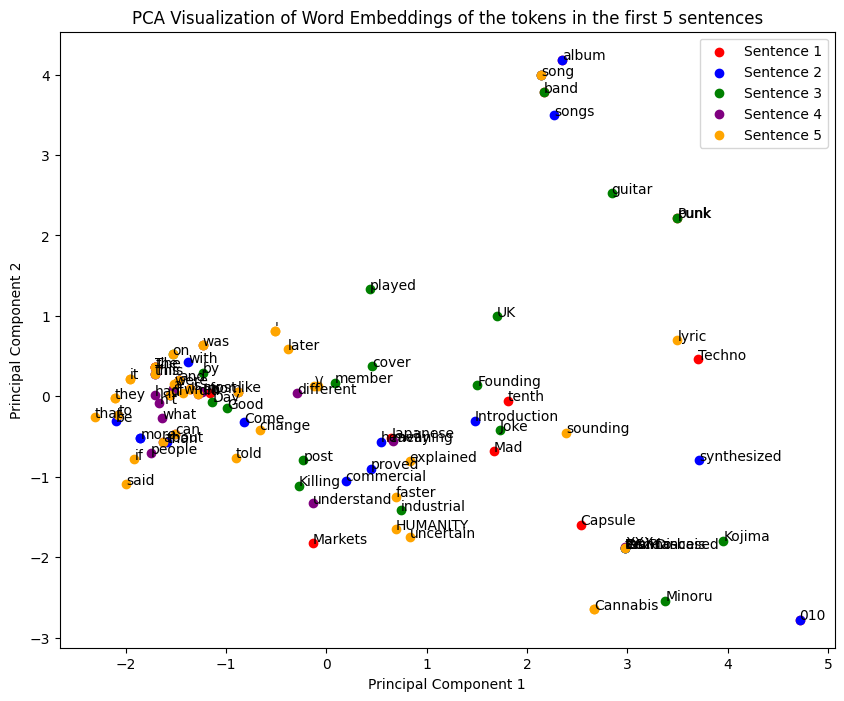

In [ ]:
# Reduce the dimensionality of the embedding matrix in order to plot it in 2 dimensions
pca = PCA(n_components=2)
embedding_pca = pca.fit_transform(filtered_embedding_matrix)

# Code for the plot
plt.figure(figsize=(10, 8))
color_list = ['red', 'blue', 'green', 'purple', 'orange']

for idx, (start, end) in enumerate(zip(cumulative_lengths[:-1], cumulative_lengths[1:])):
  plt.scatter(embedding_pca[list(range(start,end)),0],embedding_pca[list(range(start,end)),1],label=f'List {idx+1}', color=color_list[idx])

plt.title('PCA Visualization of Word Embeddings of the tokens in the first 5 sentences')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Labels tokens
for word, i in filtered_word_index.items():
    plt.annotate(word, xy=(embedding_pca[i, 0], embedding_pca[i, 1]))

plt.legend([f'Sentence {idx + 1}' for idx in range(len(color_list))])

plt.show()


In [ ]:
sentences=[f'Sentence {idx}: {first_five_sent[idx-1]}' for idx in range(1,6)]
print('\n'.join(sentences))

Sentence 1: 010 is the tenth album from Japanese Punk Techno band The Mad Capsule Markets
Sentence 2: This album proved to be more commercial and more techno-based than Osc-Dis with heavily synthesized songs like Introduction 010 and Come
Sentence 3: Founding member Kojima Minoru played guitar on Good Day and Wardanceis cover of a song by UK post punk industrial band Killing Joke
Sentence 4: XXX can of This had a different meaning and most people did n't understand what the song was about
Sentence 5: it was later explained that the song was about Cannabis ( ' can of this ' sounding like Cannabis when said faster ) it is uncertain if they were told to change the lyric like they did on P.O.P and HUMANITY


We can observe from the plot above, for example, that musical genres and musical instruments are slowly forming a cluster in the top right corner.

## 2.4. Feed forward NN

Firstly, we defined an **embedding layer**, which is used in neural networks to convert words, represented as integer indices (the output of a tokenizer), into dense vectors of a specified dimension. We decided not to use GloVe word embedding, because feedforward neural network is a very simple model in which each layer is indipendent from the others so we know in advance that this model will be less performant than the following ones.

The first model that we have used in our project is a simple **Feed forward** neural network.\
The architecture of this model is a sequential neural network that begins with an **embedding layer** for word representation, followed by **dropout**. Dropout has been employed to prevent potential overfitting issues. After that, there are three **fully connected layers** with ReLU activation functions and a dropout between the first 2. The final layer utilizes the softmax activation function for classification into one of the five classes.

As loss function we have used **cross-entropy loss** that is appropriate when conducting non binary classifications.\
 The optimizer used is **Adam**.\
  As performance metrics we have used: accuracy, precision, and recall.

Hyperparameteres:
- epoch = 5
- batch_size = 10

We have chosen 5 epochs instead of relying on early stopping technique (as we did in the other models), because we want a first simple model and 5 epochs is a standard choice.

In [ ]:
# embedding layer
embedding_layer_ffn2 = Embedding(input_dim=len(tokenizer.word_index) + 1,
                                 output_dim=emb_dim,
                                 input_length=max_sequence_len)
# model
model = Sequential([
    embedding_layer_ffn2,
    Dropout(0.5),
    Dense(800, activation='relu'),
    Dropout(0.5),
    Dense(250, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

history = model.fit(x_train, y_train,
                    epochs=5,
                    verbose=True,
                    validation_data=(x_val, y_val),
                    batch_size=10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          772000    
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 dense (Dense)               (None, 100, 800)          80800     
                                                                 
 dropout_1 (Dropout)         (None, 100, 800)          0         
                                                                 
 dense_1 (Dense)             (None, 100, 250)          200250    
                                                                 
 dense_2 (Dense)             (None, 100, 5)            1255      
                                                                 
Total params: 1054305 (4.02 MB)
Trainable params: 105430

In [ ]:
def plot_history(history, metric1 = 'accuracy', metric2 = 'val_accuracy'):
    acc = history.history[metric1]
    val_acc = history.history[metric2]
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training')
    plt.plot(x, val_acc, 'r', label='Validation')
    plt.title(f'Training and validation {metric1}')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training')
    plt.plot(x, val_loss, 'r', label='Validation')
    plt.title('Training and validation loss')
    plt.legend()

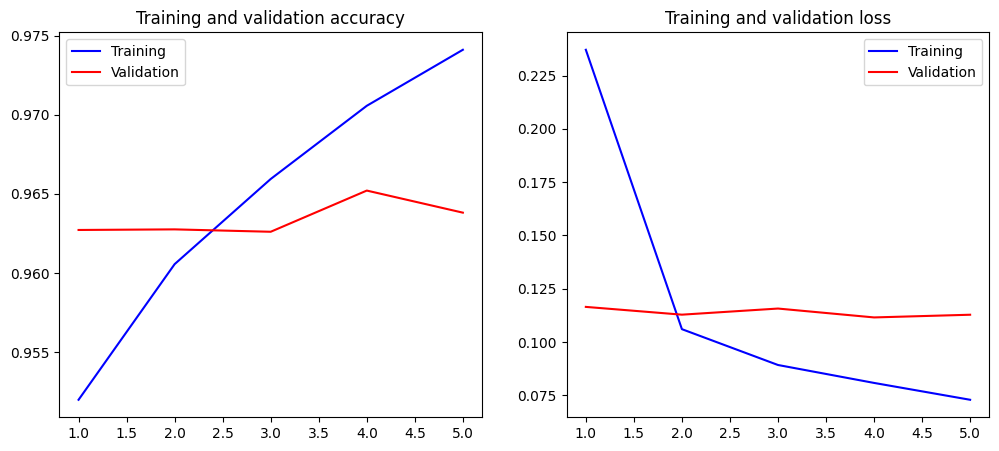

In [ ]:
plot_history(history)

From the first graph we could say that there is a quite evident overfitting issue. In fact there is a big gap between train and validation accuracy.\
Futhermore, we can assert that the model is not highly performant because the validation loss instead of decreasing is steady and quite far from 0.

In [ ]:
data_pred1 = [('Training Set', x_train, y_train), ('Test Set', x_test, y_test), ('Validation Set', x_val, y_val)]

for title, X, Y in data_pred1:
    Y_pred = model.predict(X, batch_size=10)
    Y_pred = np.array(np.argmax(Y_pred, axis=-1))
    Y = np.array(np.argmax(Y, axis=-1))
    Y, Y_pred = kerasutils.remove_seq_padding(X, Y, Y_pred)
    let_y_true, let_y_pred = modelutils.from_encode_to_literal_labels(Y, Y_pred, ids_to_labels)

    print(title)
    print(classification_report(let_y_true, let_y_pred, digits=3))
    print('\n')

106/106 [==============================] - 0s 3ms/step


/content/drive/MyDrive/Colab Notebooks/Text mining/utils/kerasutils.py:211: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Training Set
              precision    recall  f1-score   support

         LOC      0.340     0.168     0.225       578
        MISC      0.152     0.017     0.031       413
         ORG      0.255     0.538     0.346       593
         PER      0.485     0.900     0.630       529

   micro avg      0.351     0.425     0.384      2113
   macro avg      0.308     0.406     0.308      2113
weighted avg      0.316     0.425     0.322      2113



34/34 [==============================] - 0s 3ms/step
Test Set
              precision    recall  f1-score   support

         LOC      0.329     0.149     0.205       168
        MISC      0.000     0.000     0.000       148
         ORG      0.082     0.308     0.130       156
         PER      0.401     0.514     0.450       177

   micro avg      0.184     0.253     0.213       649
   macro avg      0.203     0.243     0.196       649
weighted avg      0.214     0.253     0.207       649



27/27 [==============================] - 0s 3ms/ste

Analyzing the output of the model on the test set we could say that globally the results obtained are bad, especially for Org class.

## 2.5. **LSTM**

We then decided to use a model with recurrent neural networks, specifically a **LSTM (Long Short term Memory**).\
 This type of model is superior to a traditional recurrent neural network as it can learn long-term dependencies and mitigates the vanishing gradient problem.

The architecture consists of an embedding layer followed by an LSTM layer. Subsequently, we decided to incorporate Batch Normalization.\
**Batch Normalization** is a technique that consistently accelerates the convergence of the neural network.\
 We also utilized dropout in this model; a regularization tecnique useful to prevent potential overfitting issues, and finally, two fully-connected layers, in between which we again employed batch normalization.

We used "ReLU" as the activation function in the hidden layer and "softmax" for the output layer because we are trying to address a NER classification problem and the output of the softmax can be interpreted as probabilities that a certain observation belongs to the different classes. In this case, the classes are the tags of IOB format.

In [ ]:
# embedding layer
embedding_layer=Embedding(len(tokenizer.word_index)+1,
                          emb_dim,
                          weights=[embedding_matrix],
                          input_length=max_sequence_len,
                          trainable=False)

In [ ]:
model = Sequential([
    embedding_layer,
    LSTM(emb_dim, return_sequences=True),
    BatchNormalization(),
    Dropout(0.5),
    Dense(30, activation='relu'),
    BatchNormalization(),
    Dense(5, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',Precision(),Recall()])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          772000    
                                                                 
 lstm (LSTM)                 (None, 100, 100)          80400     
                                                                 
 batch_normalization (Batch  (None, 100, 100)          400       
 Normalization)                                                  
                                                                 
 dropout_2 (Dropout)         (None, 100, 100)          0         
                                                                 
 dense_3 (Dense)             (None, 100, 30)           3030      
                                                                 
 batch_normalization_1 (Bat  (None, 100, 30)           120       
 chNormalization)                                     

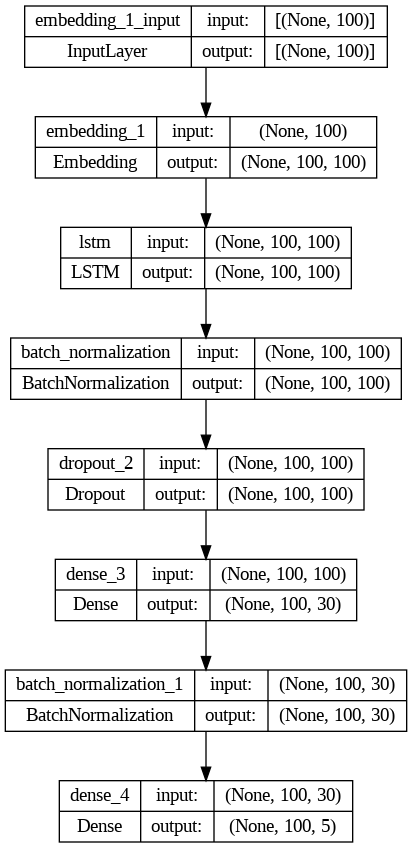

In [ ]:
plot_model(model,show_shapes=True, show_layer_names=True)

In [ ]:
best_model_file = os.path.join('/content/drive/MyDrive/Colab Notebooks/Text mining','lstm-wiki-gold-best-model.h5')
checkpoint = ModelCheckpoint(
    best_model_file,
    save_weights_only=True,
    save_best_only=True
)

# Less aggressive Early Stopping
early_stopping_callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=3, verbose=1, mode="auto", restore_best_weights=True)

In the implementation of LSTM RNN, we decide to use the early stopping technique in order to avoid overfitting and underfitting issues. <br> This technique monitors the evolution of the validation loss during the different epochs and it stops training when the monitored metric has stopped improving, i.e. there is an absolute change of less than min_delta, will count as no improvement. For this reason we set a larger number of training epochs (100) than may normally be required.

In [ ]:
# batch size
batch_size = 10

history = model.fit(x_train,
          y_train,
          batch_size=batch_size,
          epochs=100,
          verbose=2,
          callbacks=[checkpoint, early_stopping_callback],
          validation_data=(x_val, y_val)
         )

Epoch 1/100
106/106 - 8s - loss: 1.3293 - accuracy: 0.6686 - precision: 0.6671 - recall: 0.1070 - val_loss: 1.1518 - val_accuracy: 0.9555 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 8s/epoch - 77ms/step
Epoch 2/100
106/106 - 2s - loss: 0.4465 - accuracy: 0.9522 - precision: 0.9863 - recall: 0.8677 - val_loss: 0.4237 - val_accuracy: 0.9630 - val_precision: 0.9748 - val_recall: 0.9622 - 2s/epoch - 15ms/step
Epoch 3/100
106/106 - 1s - loss: 0.1599 - accuracy: 0.9720 - precision: 0.9821 - recall: 0.9627 - val_loss: 0.1912 - val_accuracy: 0.9638 - val_precision: 0.9683 - val_recall: 0.9626 - 1s/epoch - 10ms/step
Epoch 4/100
106/106 - 1s - loss: 0.1107 - accuracy: 0.9740 - precision: 0.9815 - recall: 0.9676 - val_loss: 0.1344 - val_accuracy: 0.9679 - val_precision: 0.9714 - val_recall: 0.9651 - 1s/epoch - 10ms/step
Epoch 5/100
106/106 - 1s - loss: 0.0941 - accuracy: 0.9749 - precision: 0.9810 - recall: 0.9701 - val_loss: 0.1008 - val_accuracy: 0.9726 - val_precision: 0.9764 - val_

The train has been stopped at the 12th epoch. No big improvements in the validation loss occurs.

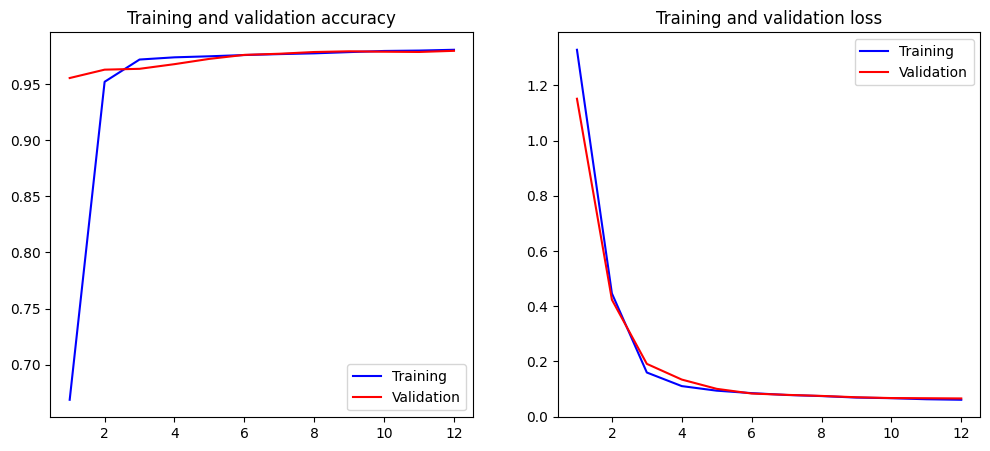

In [ ]:
plot_history(history)

Looking at the accuracy plot we can see a huge improvement with respect to the simple feedforward neural network. Just looking at the first 4 epochs it is possible to notice that the accuracy for both the training and the validation sets is greater than 95%.\
 This model,then, is not affected by overfitting.

In this case, the loss function of both the training and the validation set monotonically decrease.

In [ ]:
data_pred = [('Training Set', x_train, y_train), ('Test Set', x_test, y_test), ('Validation Set', x_val, y_val)]

for title, X, Y in data_pred:
    Y_pred = model.predict(X, batch_size=batch_size)
    Y_pred = np.array(np.argmax(Y_pred, axis=-1))
    Y = np.array(np.argmax(Y, axis=-1))
    Y, Y_pred = kerasutils.remove_seq_padding(X, Y, Y_pred)
    let_y_true, let_y_pred = modelutils.from_encode_to_literal_labels(Y, Y_pred, ids_to_labels)

    print(title)
    print(classification_report(let_y_true, let_y_pred, digits=3))
    print('\n')

106/106 [==============================] - 1s 5ms/step
Training Set
              precision    recall  f1-score   support

         LOC      0.623     0.635     0.629       578
        MISC      0.383     0.286     0.327       413
         ORG      0.379     0.352     0.365       593
         PER      0.759     0.786     0.773       529

   micro avg      0.556     0.525     0.540      2113
   macro avg      0.536     0.515     0.523      2113
weighted avg      0.542     0.525     0.532      2113



34/34 [==============================] - 0s 6ms/step
Test Set
              precision    recall  f1-score   support

         LOC      0.568     0.625     0.595       168
        MISC      0.457     0.250     0.323       148
         ORG      0.220     0.212     0.216       156
         PER      0.709     0.729     0.719       177

   micro avg      0.508     0.468     0.488       649
   macro avg      0.488     0.454     0.463       649
weighted avg      0.497     0.468     0.476       649

Looking at the F1-score on the test set, we have obtained satisfactory results for PER and LOC classes (over 50%). On the other hand, we have not obtained big improvemenets for MISC and ORG.

## 2.6. **BiLSTM**


We have decided to use another model **Bidirectional LSTM**.\
 Unlike the previous model, in BiLSTM the input flows in both directions, allowing it to capture contextual information both forward and backward in the input sequence.

The architecture of the model consists of an **embedding layer**, followed by a **Bidirectional LSTM layer** that uses two separate LSTM units to process the input sequence in both forward and backward directions. Afterward, **dropout** is introduced to prevent overfitting issues. Following that, there are **2 fully connected layers**.

Also in this model, we have used batch normalization layer, both after the embedding layer and in between the 2 fully connected layers, in order to improve our model results.

**ReLU** is used as the activation function in the hidden layer, and **softmax** is applied in the output layer.

As performance metrics we have used: accurancy, precision and recall.

In [ ]:
# embedding layer
embedding_layer=Embedding(len(tokenizer.word_index)+1,
                          emb_dim,
                          weights=[embedding_matrix],
                          input_length=max_sequence_len,
                          trainable=False)


In [ ]:
# model
model=Sequential([
    embedding_layer,
    Bidirectional(LSTM(emb_dim,return_sequences=True)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(30,activation='relu'),
    BatchNormalization(),
    Dense(5,activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',Precision(),Recall()])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          772000    
                                                                 
 bidirectional (Bidirection  (None, 100, 200)          160800    
 al)                                                             
                                                                 
 batch_normalization_2 (Bat  (None, 100, 200)          800       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 100, 200)          0         
                                                                 
 dense_5 (Dense)             (None, 100, 30)           6030      
                                                                 
 batch_normalization_3 (Bat  (None, 100, 30)          

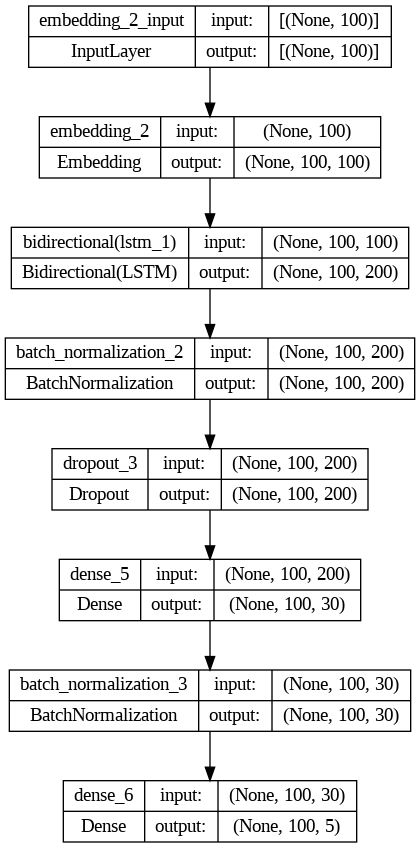

In [ ]:
plot_model(model,show_shapes=True, show_layer_names=True)

In [ ]:
best_model_file = os.path.join('/content/drive/MyDrive/Colab Notebooks/Text mining','bilstm-wiki-gold-best-model.h5')
checkpoint = ModelCheckpoint(
    best_model_file,
    save_weights_only=True,
    save_best_only=True
)

# Less aggressive Early Stopping
early_stopping_callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=3, verbose=1, mode="auto", restore_best_weights=True)

As in the previous model, we introduce early stopping technique in order to avoid overfitting and underfitting issues.

In [ ]:
# batch size
batch_size = 10

history = model.fit(x_train,
          y_train,
          batch_size=batch_size,
          epochs=100,
          verbose=2,
          callbacks=[checkpoint, early_stopping_callback],
          validation_data=(x_val, y_val)
         )

Epoch 1/100
106/106 - 10s - loss: 1.2747 - accuracy: 0.7486 - precision_1: 0.7412 - recall_1: 0.1457 - val_loss: 1.0274 - val_accuracy: 0.9622 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - 10s/epoch - 92ms/step
Epoch 2/100
106/106 - 2s - loss: 0.4164 - accuracy: 0.9598 - precision_1: 0.9847 - recall_1: 0.9078 - val_loss: 0.3840 - val_accuracy: 0.9646 - val_precision_1: 0.9775 - val_recall_1: 0.9621 - 2s/epoch - 15ms/step
Epoch 3/100
106/106 - 2s - loss: 0.1492 - accuracy: 0.9749 - precision_1: 0.9831 - recall_1: 0.9683 - val_loss: 0.2014 - val_accuracy: 0.9667 - val_precision_1: 0.9727 - val_recall_1: 0.9631 - 2s/epoch - 22ms/step
Epoch 4/100
106/106 - 2s - loss: 0.0989 - accuracy: 0.9769 - precision_1: 0.9825 - recall_1: 0.9729 - val_loss: 0.1223 - val_accuracy: 0.9722 - val_precision_1: 0.9768 - val_recall_1: 0.9680 - 2s/epoch - 24ms/step
Epoch 5/100
106/106 - 1s - loss: 0.0805 - accuracy: 0.9792 - precision_1: 0.9835 - recall_1: 0.9756 - val_loss: 0.0898 - val_accuracy:

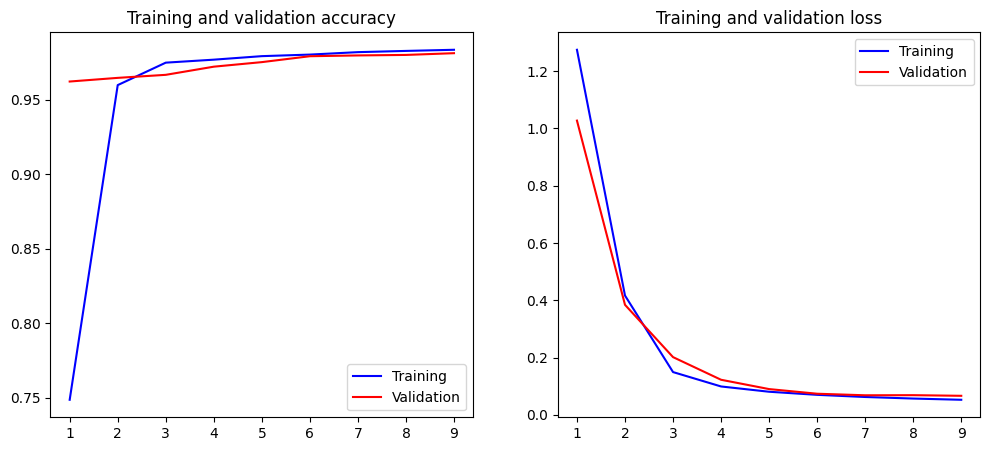

In [ ]:
plot_history(history)

The trend of both the 2 metrics is very similar to those of the LSTM.

In [ ]:
data_pred = [('Training Set', x_train, y_train), ('Test Set', x_test, y_test), ('Validation Set', x_val, y_val)]

for title, X, Y in data_pred:
    Y_pred = model.predict(X, batch_size=batch_size)
    Y_pred = np.array(np.argmax(Y_pred, axis=-1))
    Y = np.array(np.argmax(Y, axis=-1))
    Y, Y_pred = kerasutils.remove_seq_padding(X, Y, Y_pred)
    let_y_true, let_y_pred = modelutils.from_encode_to_literal_labels(Y, Y_pred, ids_to_labels)

    print(title)
    print(classification_report(let_y_true, let_y_pred, digits=3))
    print('\n')

106/106 [==============================] - 1s 7ms/step
Training Set
              precision    recall  f1-score   support

         LOC      0.677     0.562     0.614       578
        MISC      0.406     0.356     0.379       413
         ORG      0.391     0.417     0.404       593
         PER      0.789     0.694     0.738       529

   micro avg      0.560     0.514     0.536      2113
   macro avg      0.566     0.507     0.534      2113
weighted avg      0.572     0.514     0.540      2113



34/34 [==============================] - 0s 9ms/step
Test Set
              precision    recall  f1-score   support

         LOC      0.634     0.494     0.555       168
        MISC      0.417     0.270     0.328       148
         ORG      0.242     0.301     0.269       156
         PER      0.785     0.661     0.718       177

   micro avg      0.504     0.442     0.471       649
   macro avg      0.519     0.432     0.467       649
weighted avg      0.531     0.442     0.479       649

Looking at the F1-score of the test set, we notice that the results obtained are quite the same of those of the LSTM.

## 2.7 Conclusions

To sum up, the models based on Recurrent Neural Networks provide, globally, better results than the feedforward neural networks because RNN consider more information and exploit the Long-Short term memory concept.\
 Between the RNN models employed we have not notice such a big difference in the performance even if the BiLSTM uses more information.

# 3. **BERT**

In this third part, we'll be employing *BertForTokenClassification* from the *HuggingFace Transformers* library. This model is built using the BERT architecture featuring a token classification head that enables predictions at the token level instead of only at the sequence level.

As named entity recognition is typically approached as a token classification problem (the annotation scheme is defined at the word level), this model is well-suited for our purposes.

We are exploiting the concept of **transfer learning**, because we are taking a large neural network which was already pretrained in an unsupervised way (bert-base-uncased) and we are using it for training/fine-tuning on our labeled named entity recognition (NER) dataset. Indeed, fine-tuning involves supervised learning and needs a labeled dataset.

Let's proceed with installing and importing all the necessary libraries for utilizing the BERT model.

In [ ]:
import pandas as pd
import csv
import numpy as np

In [ ]:
!pip install transformers seqeval[gpu]

In [ ]:
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification

Before we start, let's switch to the GPU device and verify if CUDA is available.

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


## 3.1. Data reloading and preprocessing for BERT

In [ ]:
file_path = 'https://media.githubusercontent.com/media/nluninja/nlp_datasets/main/wikigold/data/wikigold.conll.txt'

In [ ]:
data = pd.read_csv(file_path, sep=' ', header=None, names=['Token', 'Tag'], quoting=csv.QUOTE_NONE)
data

,Token,Tag
0,010,I-MISC
1,is,O
2,the,O
3,tenth,O
4,album,O
...,...,...
39147,a,O
39148,Russian,I-MISC
39149,singer,O
39150,.,O


Our dataset uses the IOB-tagging annotation scheme which is defined, as we have initially said, at the word level. IOB stands for Inside-Outside-Beginning i.e. each tag indicates whether the corresponding word is inside, outside or at the beginning of a specific named entity, where the possible name entities are LOC, PERS, MISC, ORG.

We begin by creating two dictionaries: one that associates individual tags with indices and another that links indices to their respective tags. This step will be essential for generating labels later in the process.

In [ ]:
labels_to_ids = {k: v for v, k in enumerate(data.Tag.unique())}
ids_to_labels = {v: k for v, k in enumerate(data.Tag.unique())}

We now need to group the tokens into sentences, which will serve as inputs for the BERT model. We'll assume a sentence concluded when we encounter either a dot or an esclamation mark or a question mark.

In [ ]:
data['Sentence #'] = 0

sentence_count = 1

for i in range(len(data)):
    if data['Token'][i] in ['.', '!', '?']:
        sentence_count += 1
    data.at[i, 'Sentence #'] = f'Sentence: {sentence_count}'

data

,Token,Tag,Sentence #
0,010,I-MISC,Sentence: 1
1,is,O,Sentence: 1
2,the,O,Sentence: 1
3,tenth,O,Sentence: 1
4,album,O,Sentence: 1
...,...,...,...
39147,a,O,Sentence: 1660
39148,Russian,I-MISC,Sentence: 1660
39149,singer,O,Sentence: 1660
39150,.,O,Sentence: 1661


We now filter a bit the dataset in order not to include the basic punctuation and the -DOCSTART- tokens.

In [ ]:
punctuation = {'.', ',', ';', ':', '?', '!'}
remove_tokens = ['-DOCSTART-']

data.loc[:, 'Filtered'] = ~((data['Token'].isin(punctuation)) | (data['Token'].isin(remove_tokens)))


wiki = data.loc[data['Filtered']]

wiki = wiki.drop(columns=['Filtered'])
wiki

,Token,Tag,Sentence #
0,010,I-MISC,Sentence: 1
1,is,O,Sentence: 1
2,the,O,Sentence: 1
3,tenth,O,Sentence: 1
4,album,O,Sentence: 1
...,...,...,...
39145,Gazmanov,I-PER,Sentence: 1660
39146,is,O,Sentence: 1660
39147,a,O,Sentence: 1660
39148,Russian,I-MISC,Sentence: 1660


We then create two columns, namely 'sentence' and 'word_labels', which group the words by sentence and the tags by sentence respectively, and finally we drop the unneeded columns and the duplicate rows.

In [ ]:
wiki['sentence'] = wiki[['Sentence #','Token','Tag']].groupby(['Sentence #'])['Token'].transform(lambda x: ' '.join(x))

wiki['word_labels'] = wiki[['Sentence #','Token','Tag']].groupby(['Sentence #'])['Tag'].transform(lambda x: ','.join(x))

wiki.head()

,Token,Tag,Sentence #,sentence,word_labels
0,010,I-MISC,Sentence: 1,010 is the tenth album from Japanese Punk Tech...,"I-MISC,O,O,O,O,O,I-MISC,O,O,O,I-ORG,I-ORG,I-OR..."
1,is,O,Sentence: 1,010 is the tenth album from Japanese Punk Tech...,"I-MISC,O,O,O,O,O,I-MISC,O,O,O,I-ORG,I-ORG,I-OR..."
2,the,O,Sentence: 1,010 is the tenth album from Japanese Punk Tech...,"I-MISC,O,O,O,O,O,I-MISC,O,O,O,I-ORG,I-ORG,I-OR..."
3,tenth,O,Sentence: 1,010 is the tenth album from Japanese Punk Tech...,"I-MISC,O,O,O,O,O,I-MISC,O,O,O,I-ORG,I-ORG,I-OR..."
4,album,O,Sentence: 1,010 is the tenth album from Japanese Punk Tech...,"I-MISC,O,O,O,O,O,I-MISC,O,O,O,I-ORG,I-ORG,I-OR..."


In [ ]:
wiki = wiki[["sentence", "word_labels"]].drop_duplicates().reset_index(drop=True)
wiki.head()

,sentence,word_labels
0,010 is the tenth album from Japanese Punk Tech...,"I-MISC,O,O,O,O,O,I-MISC,O,O,O,I-ORG,I-ORG,I-OR..."
1,This album proved to be more commercial and mo...,"O,O,O,O,O,O,O,O,O,O,O,I-MISC,O,O,O,O,O,I-MISC,..."
2,Founding member Kojima Minoru played guitar on...,"O,O,I-PER,I-PER,O,O,O,I-MISC,I-MISC,O,I-MISC,O..."
3,XXX can of This had a different meaning and mo...,"I-MISC,I-MISC,I-MISC,I-MISC,O,O,O,O,O,O,O,O,O,..."
4,it was later explained that the song was about...,"O,O,O,O,O,O,O,O,O,I-MISC,O,O,O,O,O,O,O,O,I-MIS..."


We check also the maximum sentence lenght among all the sentences and the final shape of the dataset.

In [ ]:
max_length_sentence = wiki['sentence'].apply(lambda x: len(x.split())).max()

print("Maximum length of a sentence:", max_length_sentence)

Maximum length of a sentence: 110


In [ ]:
wiki.shape

(1655, 2)

## 3.2. Parameters and dataloader setting

We start by defining the model parameters that will be used later on in the training/evaluation process.

In [ ]:
MAX_LEN = 110
TRAIN_BATCH_SIZE = 5
VALID_BATCH_SIZE = 5
EPOCHS = 5
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 1
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Below, we define a regular PyTorch dataset class that converts each enter of the dataframe to a PyTorch tensor.

This involves:

*   Tokenizing each sentence;
*   Incorporating the special tokens expected by BERT;
*   Padding or truncating tokens according to the model's maximum length;
*   Generating an attention mask;
*   Creating labels based on the previously defined dictionary.

Notice that if a word has a label of $-100$ it will be be ignored (default *ignore_index* of *PyTorch CrossEntropyLoss*).

In [ ]:
class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):

        sentence = self.data.sentence[index].strip().split()
        word_labels = self.data.word_labels[index].split(",")

        encoding = self.tokenizer(sentence,
                                  is_split_into_words = True,
                                  return_offsets_mapping=True,
                                  padding='max_length',
                                  truncation=True,
                                  max_length=self.max_len)

        labels = [labels_to_ids[label] for label in word_labels]

        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100 # len(encoding["offset_mapping"] == max_len

        i = 0

        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            encoded_labels[idx] = labels[i]
            i += 1

        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)

        return item

  def __len__(self):
        return self.len


The core of the code above is responsible for mapping word-level labels to token-level labels and encoding them into the appropriate format. First a counter is initialised to keep track of the current position in the list labels.

Then, we iterate over the enumerated offset mappings. The offset_mapping provides the mapping of tokens to their corresponding character offsets in the original sentence.

The following if condition checks if the current token corresponds to the start of a word (offset $0$ at the beginning of a word) and if it's not a padding token (offset $1$ at the end of a padding token). If the consition is entered we assigns the label of the current word to the corresponding token in the encoded sequence.

This mapping is necessary because BERT tokenizes the input sentences and we need to align the labels with the corresponding tokens to ensure that each token gets assigned the appropriate label based on the word it originates from in the original sentence.

Notice that tokenizer used for encoding is the *BertTokenizerFast* defined above, which provides the *return_offsets_mapping* argument in order to set whether or not to return (char_start, char_end) for each token.

**Source:** https://huggingface.co/docs/transformers/internal/tokenization_utils

## 3.3. Train - test split

We can now create two datasets, one for training and one for testing, based on the dataset class defined above, using a $80/20$ split and then define the corresponding PyTorch dataloaders.

In [ ]:
train_size = 0.8
train_dataset = wiki.sample(frac=train_size,random_state=200)
test_dataset = wiki.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(wiki.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (1655, 2)
TRAIN Dataset: (1324, 2)
TEST Dataset: (331, 2)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

## 3.4. Model definition

Here we define the model, *BertForTokenClassification*, load it with the pretrained weights of *bert-base-uncased*, and move it to the GPU. We need only to additionally specify the number of labels (which will determine the architecture of the classification head).

In [ ]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(labels_to_ids))
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

## 3.5. Training phase

We now define the optimizer (Adam has been chosen) and the train function.

**Source:** https://github.com/chambliss/Multilingual_NER/blob/master/python/utils/main_utils.py#L344

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [ ]:
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []

    model.train()

    for idx, batch in enumerate(training_loader):

        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
        loss = outputs.loss # cross-entropy loss
        tr_logits = outputs.logits
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)

        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")

        flattened_targets = labels.view(-1)
        active_logits = tr_logits.view(-1, model.num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1)

        active_accuracy = labels.view(-1) != -100

        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy

        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss: {epoch_loss}")
    print(f"Training accuracy: {tr_accuracy}")

In [ ]:
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

Training epoch: 1
Training loss per 100 training steps: 1.6926405429840088
Training loss per 100 training steps: 0.6838990591540195
Training loss per 100 training steps: 0.4792950600385666
Training loss: 0.4142406373794349
Training accuracy: 0.8727182752415609
Training epoch: 2
Training loss per 100 training steps: 0.3054376244544983
Training loss per 100 training steps: 0.14438893963204752
Training loss per 100 training steps: 0.13733347661478157
Training loss: 0.1294633192590104
Training accuracy: 0.9602774637982535
Training epoch: 3
Training loss per 100 training steps: 0.035086970776319504
Training loss per 100 training steps: 0.07475085479972682
Training loss per 100 training steps: 0.06634111557531157
Training loss: 0.06372683404523106
Training accuracy: 0.9810798057618494
Training epoch: 4
Training loss per 100 training steps: 0.032851479947566986
Training loss per 100 training steps: 0.03908587552118346
Training loss per 100 training steps: 0.03777672695366675
Training loss: 0.

As we can see from the print statements above, after the training phase the model has achieved a $99\%$ training accuracy.

## 3.6. Validation

Now that we've trained our model, we can evaluate its performance on the test set (formed by $20\%$ of the data). Notice that here, since the gradient itself is not needed, no gradient updates are performed in order to save computational time and space.

In [ ]:
def valid(model, testing_loader):

    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []

    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):

            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
            loss = outputs.loss
            eval_logits = outputs.logits
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)

            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")

            flattened_targets = labels.view(-1)
            active_logits = eval_logits.view(-1, model.num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1)

            active_accuracy = labels.view(-1) != -100

            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            eval_labels.extend(labels)
            eval_preds.extend(predictions)

            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [ ]:
labels, predictions = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 0.18545804917812347
Validation Loss: 0.12960181996111633
Validation Accuracy: 0.9674661342481959


The validation accuracy on the test set is about $97\%$. Let's display also some additional metrics.

In [ ]:
from seqeval.metrics import classification_report

print(classification_report([labels], [predictions]))

              precision    recall  f1-score   support

         LOC       0.77      0.87      0.82       179
        MISC       0.72      0.77      0.74       144
         ORG       0.67      0.67      0.67       156
         PER       0.95      0.91      0.93       170

   micro avg       0.78      0.81      0.79       649
   macro avg       0.78      0.81      0.79       649
weighted avg       0.78      0.81      0.80       649



Finally, we are using a confusion matrix to display the classification results on the test set.

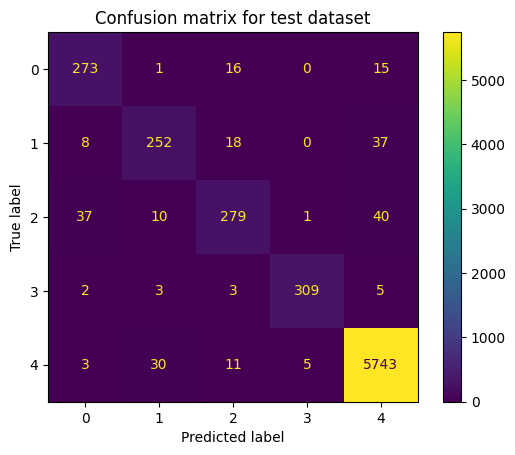

In [ ]:
import sklearn.metrics
import matplotlib.pyplot as plt

confusion_matrix = sklearn.metrics.confusion_matrix(labels, predictions)

confusion_matrix_plot = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix)
confusion_matrix_plot.plot()
plt.title("Confusion matrix for test dataset")
plt.show()

# 4. Model comparison

For our named entity recognition (NER) task we have trained four different models based on a diverse range of architectures (from traditional neural networks to more advanced transformer-based models). Let's conlude our research with a comparison.

All models share the common goal of classifying named entities within the same given (wiki) text: locations (LOC), miscellaneous entities (MISC), organizations (ORG), and persons (PER).

For what it concernes the **accuracy**, the models exhibit relatively higher performance on the training sets compared to the validation and test sets, indicating a potential risk of **OVERFITTING**.

All models try to handle class imbalances, in particular lower performance in classes such as LOC and ORG are noticeable. Accuracy is a metric that is based on the assumption of balaced distribution of the data in the different classes. If this is not the case, like in wiki text, accuracy is a biased measure of goodness of the model.

For this reason, we decided to calculate the **F1 scores** for each model, where F1 score is the armonic mean of precision and recall, providing a balance between these two metrics, which is better that simply study the accuracy above all in case of classification problems. It is calculated using the following formula:


$F1-score = 2 \times \frac{precision \times recall}{precision + recall}$

In our case we used two slighlty different mectrics namely micro and macro F1 scores, which are two different ways to aggregate and summarize the individual class F1 scores in a multi-class classification problem.

\

* $Micro \ precision = \frac{\sum true \ positives }{\sum (true \ positives + false \ positives)}$

* $Micro \ recall = \frac{\sum true \ positives }{\sum (true \ positives + false \ negatives)}$

* $Macro \ precision = \frac{avg \ precision \ across \ classes}{number \ of \ classes}$

* $Macro \ recall = \frac{avg \ recall \ across \ classes}{number \ of \ classes}$

* $Micro \ F1-score = 2 \times \frac{Micro \ precision \times Micro \ recall}{Micro \ precision + Micro \ recall}$

* $Macro \ F1-score = 2 \times \frac{Macro \ precision \times Macro \ recall}{Macro \ precision + Macro \ recall}$

\

Notice that micro F1 score is suitable when there is a class imbalance because it gives more weight to the larger classes i.e. it treats all instances equally, irrespective of their class. On the other hand, in the macro F1 score, the F1 score is calculated for each class independently and then an average is taken i.e. each class contributes equally to the macro F1 score.
The macro F1 score is then sensitive to performance in smaller classes and can help identify how well the model is performing across all classes.

>  1. **Feed Forward NN**: \
Test Set:
*  Micro F1-score: $\approx 0.30$ \
*  Macro F1-score: $\approx 0.30$
>  2. **LSTM**: \
Test Set:
*  Micro F1-score: $\approx 0.40$ \
*  Macro F1-score: $\approx 0.40$
>  3. **BiLSTM**: \
Test Set:
*  Micro F1-score: $\approx 0.45$
*  Macro F1-score: $\approx 0.40$
>  4. **BERT**: \
Test Set:
*  Micro F1-score: $\approx 0.80$ \
*  Macro F1-score: $\approx 0.80$

BERT model appears to outperform the other models, achieving higher F1-scores on the test set. LSTM and BILSTM show similar performance and ouperform the simple Feed Forward NN, which has the lowest performance among the models.

In general, the feed forward NN achieves moderate overall F1-scores, with lower precision and recall, indicating a balance between false positives and false negatives.
LSTM improved all F1-scores, particularly in the micro and macro averages, suggesting better generalization.
BiLSTM performs similarly to the previous one so it seems that no big improvement is given by the additional LSTM layer introduced by this model, while BERT outperforms other models, achieving higher precision, recall, and F1-scores, showing the effectiveness of BERT's contextual embeddings, also in a smaller number of epochs.

Regarding the training duration, training times varied significantly, with simpler architectures like the first one requiring substantially less time compared to more complex models like BERT, for which a GPU was strictly needed.